###  What is Iterative Retrieval in Agentic RAG?
Combined both Iterative And Self reflection

 Definition:
Iterative Retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary, it:

- Refines the query,
- Retrieves again,
- Repeats the process until it’s confident enough to answer the original question.

### Why Use It?
In standard RAG:

- A single retrieval step is done, and the LLM uses it to answer.
- If the documents were incomplete or irrelevant, the answer may fail.

In Iterative RAG:

- The agent reflects on the retrieved content and the answer it produced.
- If it’s unsure, it can refine its search (like a human researcher would).

retrieve → answer → retrieve → answer


In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

In [2]:
### load llm models
import os
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-20b")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [4]:
### Load And Embed Documents
docs = TextLoader("research-notes.txt", encoding="utf-8").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [5]:
### Define Agent State

class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0


In [6]:
### Retrieve Node
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    docs = retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs": docs})

In [7]:
### Reflect And Verify
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt = f"""Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    response = llm.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [8]:
## Reflect on answer
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = llm.invoke(prompt).content.lower()
    verified = "yes" in feedback
    return state.model_copy(update={"verified": verified})

In [9]:
## Refine query
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
"""
    new_query = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question": new_query})

In [13]:
builder = StateGraph(IterativeRAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("answer", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")

builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.verified or s.attempts >= 2 else "refine"
)

builder.add_edge("refine", "retrieve")
builder.add_edge("answer", END)

graph = builder.compile()


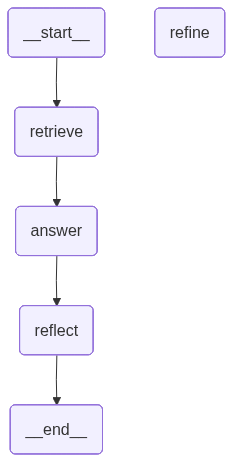

In [14]:
graph

In [15]:
query = "agent loops  and transformer-based systems?"

initial_state = IterativeRAGState(question=query)
final = graph.invoke(initial_state)

print("Final Answer:\n", final["answer"])
print("\n Verified:", final["verified"])
print(" Attempts:", final["attempts"])

Final Answer:
 **Agent Loops + Transformer‑Based Systems – A Quick Primer**

| Concept | What it is | How it shows up in the log | Why it matters |
|---------|------------|----------------------------|----------------|
| **Agent Loop** | A control loop that repeatedly: 1) *perceives* a user query or environment state, 2) *plans* a next action, 3) *acts* (e.g., calls a tool or generates text), 4) *observes* the result, and 5) *updates* its internal state. | • “Tool‑augmented prompting” with LangGraph, Wikipedia, SQL search.<br>• “RAG for chatbot Q&A” – the LLaMA2 model calls a retrieval agent, then re‑generates a response. | Enables *dynamic* reasoning, multi‑step problem solving, and integration of external knowledge (databases, APIs, search engines). Keeps the model grounded in real‑world data rather than just its training corpus. |
| **Transformer‑Based System** | A neural architecture that relies on self‑attention to process sequences (text, images, time‑series). Variants differ in 